<a href="https://colab.research.google.com/github/Renata-Romanelli/ML_stroke_prediction/blob/main/SVM_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing SVM Classifier algorithm to classify patient in Stroke of Healthy based on results of Cerebral Autoregulaiton methods

Cerebral Autoregulaiton results (features):
- Transfer Function analysis (Gain, Phase and Coherence)
- Autoregulaiton Index - ARI
- Autoregressive Moving Average ARI - ARMA-ARI
- Mean Flow Index - nMx

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('control&stroke_TOTALacceptance1_new.csv', sep=';')
pd.set_option("display.max.columns", None)
df.head()

,Paciente,NIHSS_init,NIHSS_med,mRS,Hemisferio,tipo,stroke_type_NIHSSmed,type_num,type_num2,poor_functional,centro,GanhoVLF,GanhoLF,GanhoHF,FaseVLF,FaseLF,FaseHF,CohVLF,CohLF,CohHF,ARI,ARI_ARMA,nMx,ari_compromisedAC,acceptance
0,P01BA1A1,3,0,0,E,stroke,mild,1,0,0,Brasil,1.372,1.469,2.001,0.694,0.466,-0.327,0.959,0.882,0.579,4.169,4.91,0.6170,0,1
1,NaN,3,0,0,D,stroke,mild,1,0,0,Brasil,1.270,1.129,2.088,0.940,0.827,0.827,0.922,0.757,0.493,6.724,5.17,0.4903,0,1
2,P02BA1A1,9,12,5,E,stroke,moderate,1,1,1,Brasil,1.497,1.527,2.076,0.622,0.543,0.118,0.860,0.898,0.935,3.255,7.04,0.7160,1,1
3,NaN,9,12,5,D,stroke,moderate,1,1,1,Brasil,1.497,1.527,2.075,0.622,0.543,0.118,0.860,0.898,0.934,3.254,7.04,0.7160,1,1
4,P03A1BA1,10,8,1,E,stroke,moderate,1,1,0,Brasil,1.093,1.050,1.038,1.168,0.526,0.164,0.697,0.415,0.829,4.803,3.01,0.4889,1,1


In [6]:
cols = {'type_num':'stroke', 'type_num2':'stroke_severe'}

df.rename(cols, inplace=True, axis=1)
df.drop(['Paciente', 'NIHSS_med'], inplace=True, axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NIHSS_init            145 non-null    int64  
 1   mRS                   145 non-null    int64  
 2   Hemisferio            145 non-null    object 
 3   tipo                  145 non-null    object 
 4   stroke_type_NIHSSmed  145 non-null    object 
 5   stroke                145 non-null    int64  
 6   stroke_severe         145 non-null    int64  
 7   poor_functional       145 non-null    int64  
 8   centro                145 non-null    object 
 9   GanhoVLF              145 non-null    float64
 10  GanhoLF               145 non-null    float64
 11  GanhoHF               145 non-null    float64
 12  FaseVLF               145 non-null    float64
 13  FaseLF                145 non-null    float64
 14  FaseHF                145 non-null    float64
 15  CohVLF                1

# Exploratory data analysis

In [ ]:
# check distribution of target variable column

df['type_num2'].value_counts()

0    89
1    56
Name: type_num2, dtype: int64

In [ ]:
df['type_num2'].value_counts()/np.float(len(df))

0    0.613793
1    0.386207
Name: type_num2, dtype: float64

We can see that percentage of observations of the class label 0 and 1 is 61.38% and 38.62%. So, this is a class imbalanced problem.

We can see that there are no missing values in the dataset and all the variables are numerical variables.

There are 12 numerical continuous variables we are interested

Text(0.5, 1.0, '')

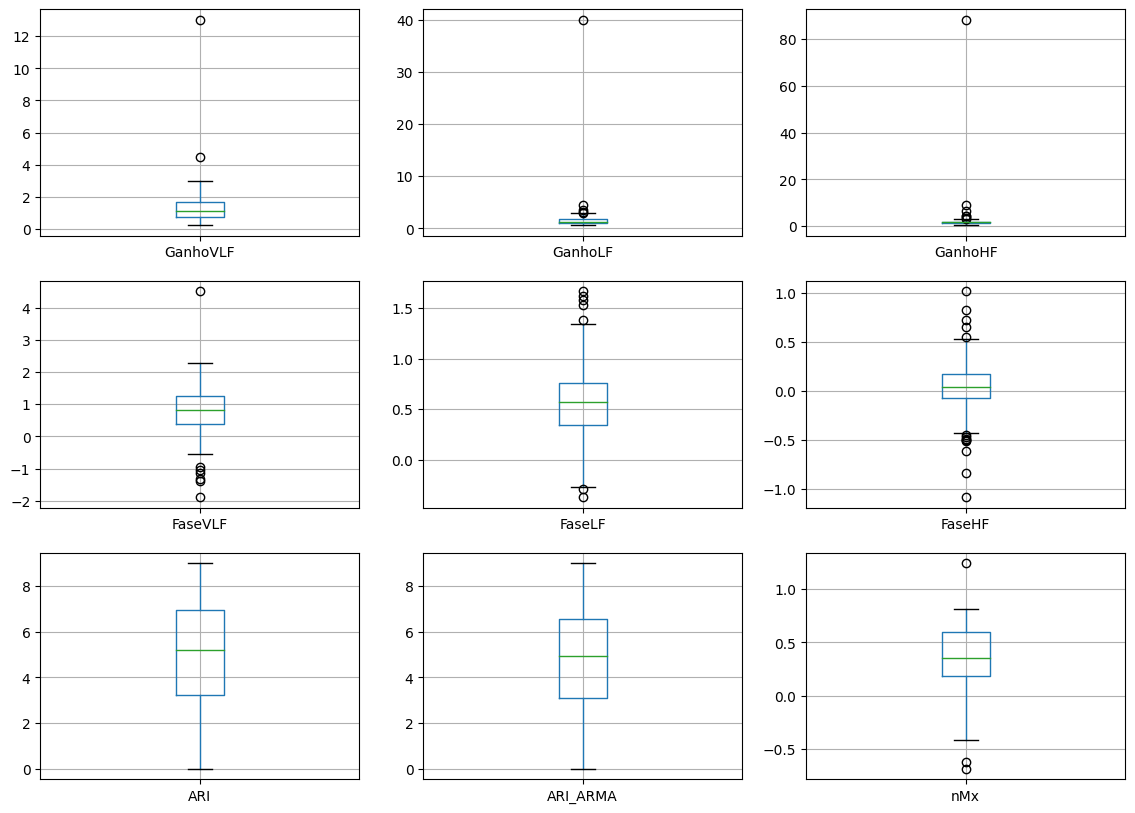

In [ ]:
# draw boxplots to visualize outliers

plt.figure(figsize=(14,10))

plt.subplot(3, 3, 1)
fig = df.boxplot(column='GanhoVLF')
fig.set_title('')

plt.subplot(3, 3, 2)
fig = df.boxplot(column='GanhoLF')
fig.set_title('')

plt.subplot(3, 3, 3)
fig = df.boxplot(column='GanhoHF')
fig.set_title('')

plt.subplot(3, 3, 4)
fig = df.boxplot(column='FaseVLF')
fig.set_title('')

plt.subplot(3, 3, 5)
fig = df.boxplot(column='FaseLF')
fig.set_title('')

plt.subplot(3, 3, 6)
fig = df.boxplot(column='FaseHF')
fig.set_title('')

plt.subplot(3, 3, 7)
fig = df.boxplot(column='ARI')
fig.set_title('')

plt.subplot(3, 3, 8)
fig = df.boxplot(column='ARI_ARMA')
fig.set_title('')

plt.subplot(3, 3, 9)
fig = df.boxplot(column='nMx')
fig.set_title('')

The above boxplots confirm that there are lot of outliers in these variables.

**Handle outliers with SVMs**

soft-margin variant of SVM: In this case, we can have a few points incorrectly classified or classified with a margin less than 1. But for every such point, we have to pay a penalty in the form of C parameter, which controls the outliers. Low C implies we are allowing more outliers and high C implies less outliers.

The message is that since the dataset contains outliers, so the value of C should be high while training the model.

Text(0.5, 0, 'nMx')

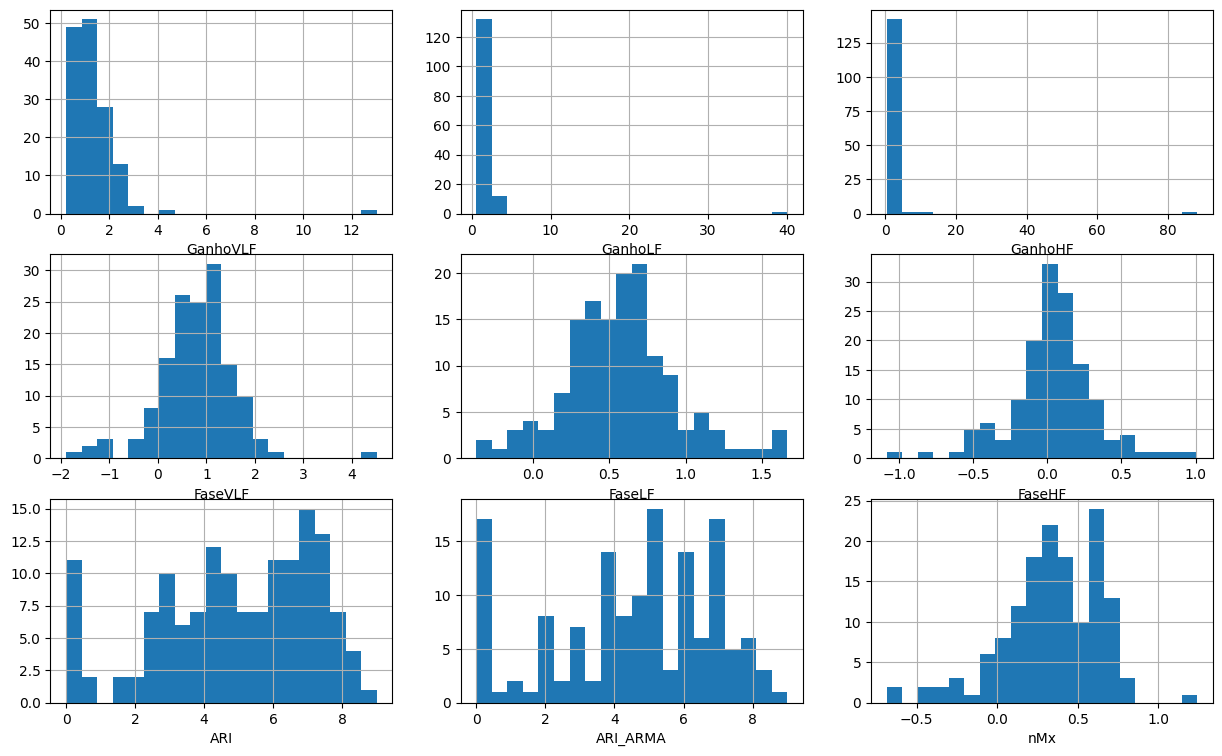

In [ ]:
# plot histogram to check distribution

plt.figure(figsize=(15,9))

plt.subplot(3, 3, 1)
fig = df['GanhoVLF'].hist(bins=20)
fig.set_xlabel('GanhoVLF')

plt.subplot(3, 3, 2)
fig = df['GanhoLF'].hist(bins=20)
fig.set_xlabel('GanhoLF')

plt.subplot(3, 3, 3)
fig = df['GanhoHF'].hist(bins=20)
fig.set_xlabel('GanhoHF')

plt.subplot(3, 3, 4)
fig = df['FaseVLF'].hist(bins=20)
fig.set_xlabel('FaseVLF')

plt.subplot(3, 3, 5)
fig = df['FaseLF'].hist(bins=20)
fig.set_xlabel('FaseLF')

plt.subplot(3, 3, 6)
fig = df['FaseHF'].hist(bins=20)
fig.set_xlabel('FaseHF')

plt.subplot(3, 3, 7)
fig = df['ARI'].hist(bins=20)
fig.set_xlabel('ARI')

plt.subplot(3, 3, 8)
fig = df['ARI_ARMA'].hist(bins=20)
fig.set_xlabel('ARI_ARMA')

plt.subplot(3, 3, 9)
fig = df['nMx'].hist(bins=20)
fig.set_xlabel('nMx')

In [ ]:
# Declare feature vector and target variable
# Test other features

df_svm = df[['FaseVLF', 'type_num2']]
X = df_svm.drop(['type_num2'], axis=1)
y = df_svm['type_num2']

In [ ]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# check the shape of X_train and X_test
X_train.shape, X_test.shape

((116, 1), (29, 1))

In [ ]:
# Feature Scaling: normalize independent variables

cols = X_train.columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [ ]:
X_train.describe()

,GanhoLF
count,1.160000e+02
mean,3.565156e-17
std,1.004338e+00
min,-3.445103e-01
25%,-2.135732e-01
50%,-1.364175e-01
75%,2.586835e-03
max,1.053616e+01


X_train dataset is ready to be fed into the Logistic Regression classifier.

**Run SVM with default hyperparameters**

Default hyperparameter means C=1.0, kernel=rbf and gamma=auto among other parameters.

In [ ]:
# import SVC classifier
from sklearn.svm import SVC

# import metrics to compute accuracy
from sklearn.metrics import accuracy_score

# instantiate classifier with default hyperparameters
svc=SVC()

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.4828


We have seen that there are outliers in our dataset. So, we should increase the value of C as higher C means fewer outliers. So, I will run SVM with kernel=rbf and C=100.0.

In [ ]:
# instantiate classifier with rbf kernel and C=100
svc=SVC(C=100.0)

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=100.0 : 0.4828


In [ ]:
# Run SVM with rbf kernel and C=1000.0

# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=1000.0)

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=1000.0 : 0.4828


Run SVM with linear kernel

In [ ]:
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0)

# fit classifier to training set
linear_svc.fit(X_train,y_train)

# make predictions on test set
y_pred_test=linear_svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with linear kernel and C=1.0 : 0.4828


In [ ]:
# instantiate classifier with linear kernel and C=100.0
linear_svc100=SVC(kernel='linear', C=100.0)

# fit classifier to training set
linear_svc100.fit(X_train, y_train)

# make predictions on test set
y_pred=linear_svc100.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=100.0 : 0.4828


In [ ]:
# instantiate classifier with linear kernel and C=1000.0
linear_svc1000=SVC(kernel='linear', C=1000.0)

# fit classifier to training set
linear_svc1000.fit(X_train, y_train)

# make predictions on test set
y_pred=linear_svc1000.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=1000.0 : 0.4828
